# Deep Q-Network (DQN)

The two problems that consistently show up in the naive application of function approximation to RL (like NFQ) are the **violations of the IID assumption** and the **non stationarity of targets**. In supervised learning, we obtain a full dataset in advance. We pre-process it, shuffle it, and then split it into sets for training. One crucial step in this process is the **shuffling of the data set**. By doing so, we allow our optimization method to avoid developing overfitting biases, reduce the variance of the training process, speed up convergence, and overall learn a more general representation of the underlying data-generating process. In reinforcement learning data is **gathered online** (they come from a sequence, a time series, a trajectory) and the experience sample generated at time step t+1 correlates with the experience sample generated at time step t. Moreover, samples are not identically distributed, because they depend on the policy that generates the actions and the policy is changing through time (it improves). Also, in supervised learning, the targets used for training are fixed values on our dataset (fixed throughout the training process). In reinforcement learning **targets move with every training step** of the network. At every training update step, we optimize the approximate value function and therefore change the shape of the function, possibly the entire value function. Changing the value function means that the target values change as well, which, in turn, means the targets used are no longer valid. Because the targets come from the network, even before we use them, we can assume targets are invalid or biased at a minimum:

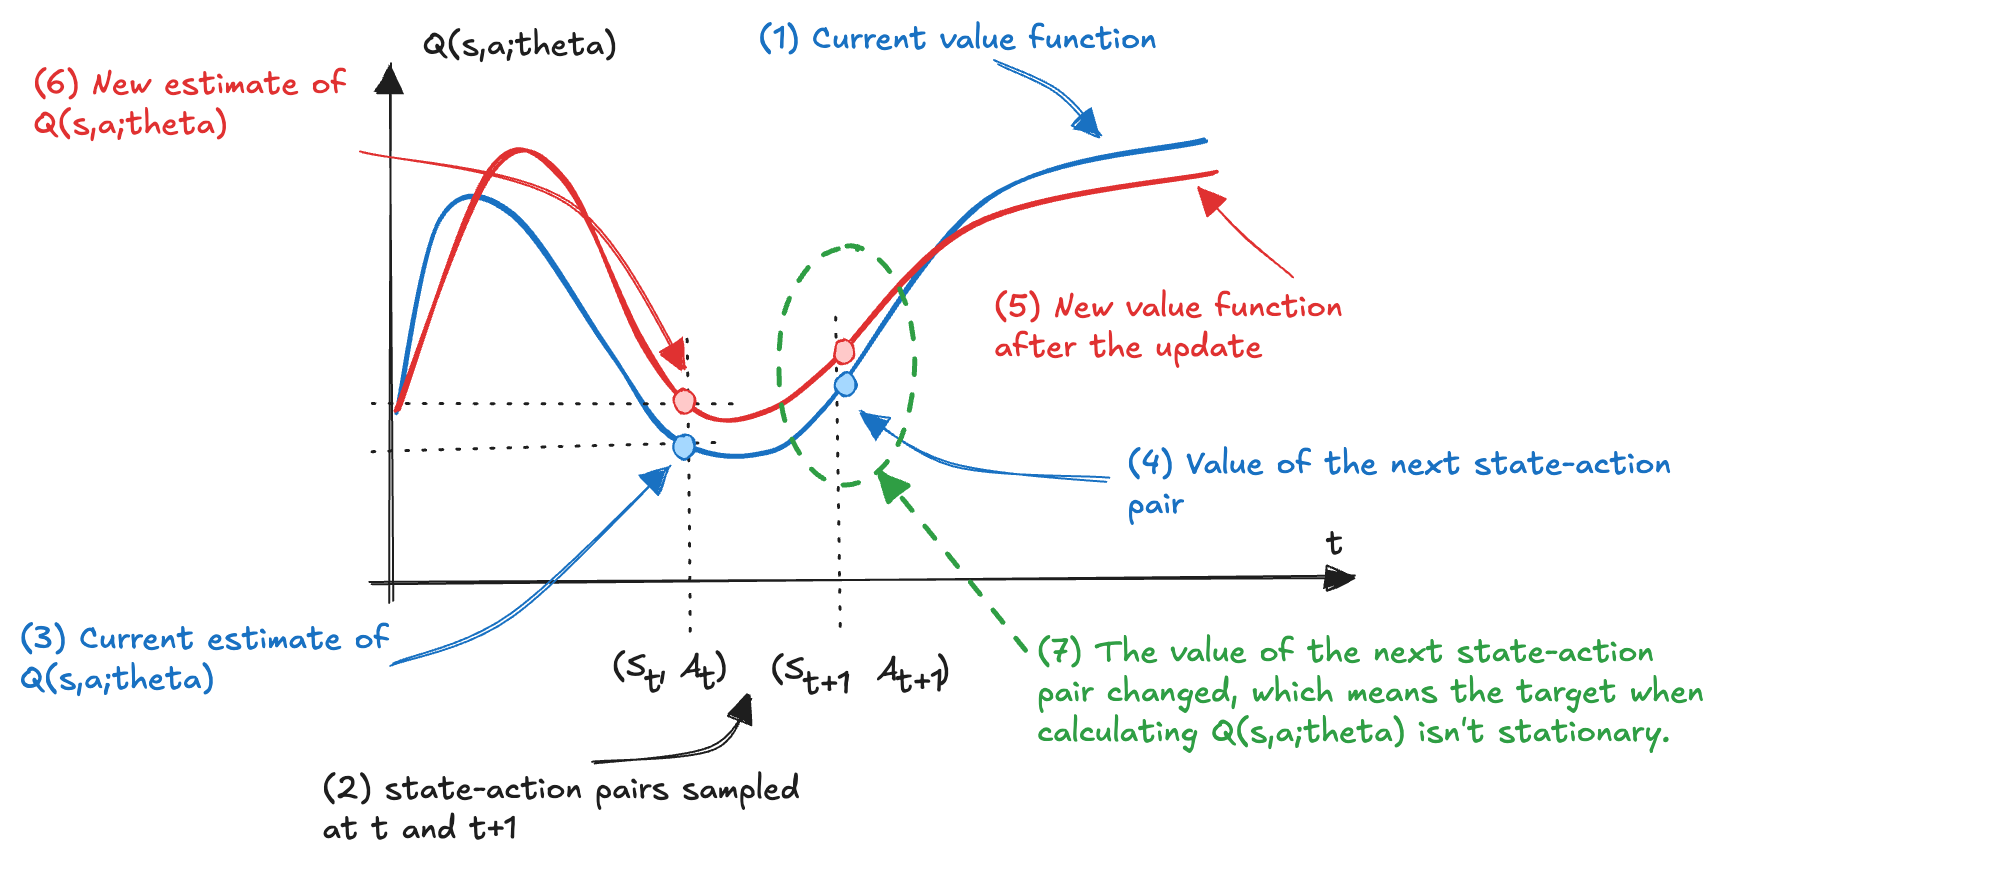

In order to address these issues, we can uses a **replay buffer** to store experience samples, a **target network** to stabilize the learning process and **more advanced exploration strategies**. Again we use the cart-pole environment to illustrate the algorith.

In [113]:
import gymnasium

cartpole = gymnasium.make('CartPole-v1', render_mode="rgb_array");

Again, we fix the seed of the random number generator in order to reproduce the results:

In [114]:
import torch;
import numpy as np;
import random;

# set the seeds for reproducibility of results
seed = 34;

torch.manual_seed(seed);
np.random.seed(seed);
random.seed(seed);
cartpole.np_random = np.random.Generator(np.random.PCG64(seed));

Since these methods are more complex, **leveraging hardware acceleration is essential** for speeding up the training process. In particular, PyTorch can take advantage of GPU acceleration to significantly reduce training time. If you have an Nvidia GPU, you can use **CUDA** for this purpose. For users with Apple Silicon devices (such as M1 or M2 chips), **MPS (Metal Performance Shaders)** is available to enable GPU acceleration.

In [115]:
# set the backend device to MPS, if available
if torch.backends.mps.is_available():
    device = torch.device("mps");
else:
    device = torch.device("cpu");

# print the used device    
print(f"Using device: {device}");

Using device: mps


Now we can move tensors and models to that device with `.to(device)` for hardware acceleration in PyTorch.

## Experience Replay

In NFQ, we use a mini-batch of N samples, and train the network with this batch for K iterations, alternating between calculating new targets and optimizing the network. These N samples are temporally correlated, because most of them belong to the same trajectory. **Experience replay** consists of a data structure (**replay memory**, called D) that **holds M>>N experience samples for several steps**, allowing the **sampling of mini-batches from a broad set of past experiences**. In that way, the training process can use a more diverse mini-batch for performing updates, and the agent no longer has to fit the model to the same small mini-batch for multiple iterations. The replay buffer **gives the impression that data are IID**, so that the optimization method is stable. Samples appear independent and identically distributed because of the sampling from multiple trajectories and even policies at once.

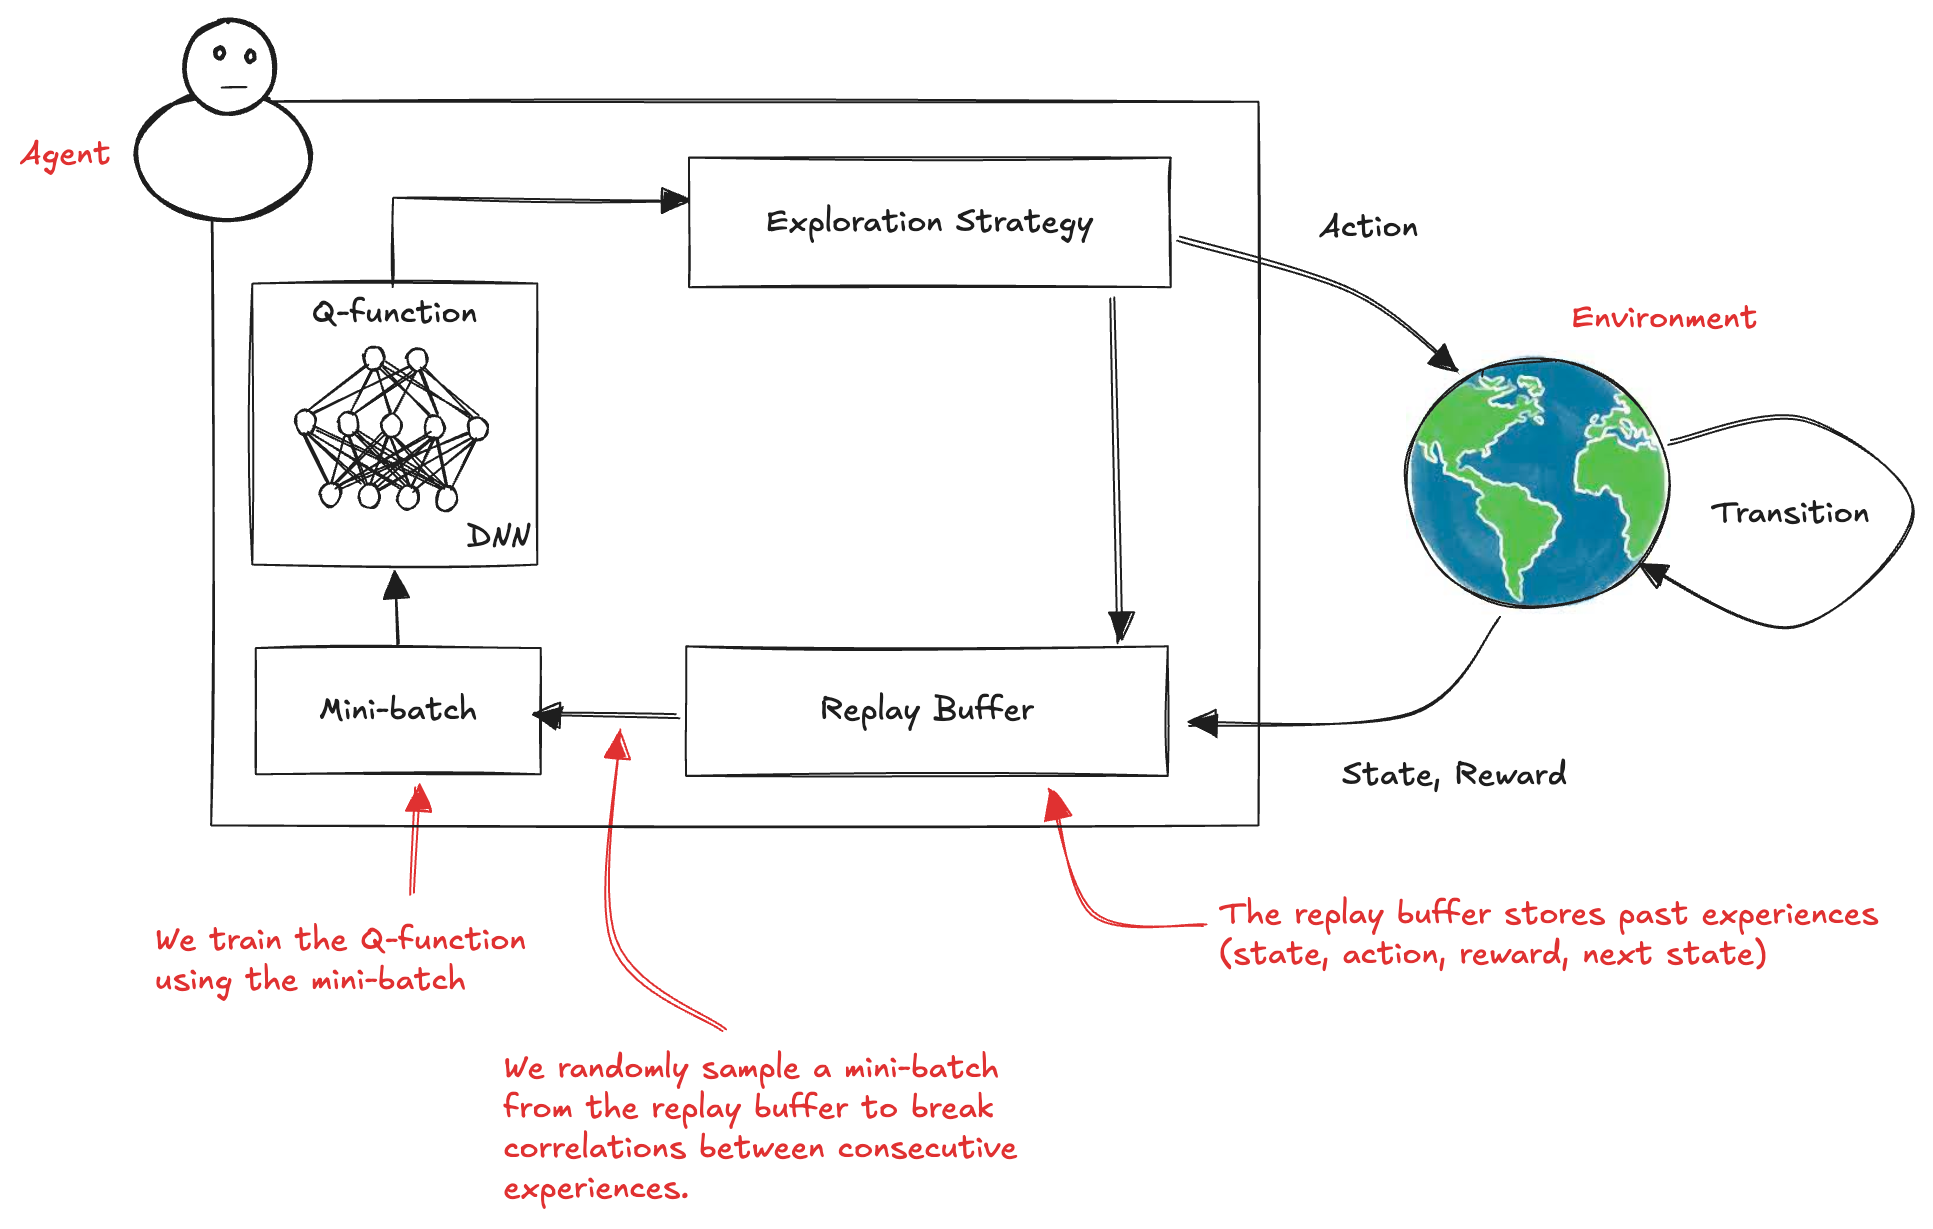

The only difference with NFQ is that **we’re now obtaining the experiences we use for training by sampling uniformly at random the replay buffer D**, instead of using the online experiences as before:

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta) - Q(s,a;\theta))^2 \right]$

Unfortunately, the **implementation becomes a challenge when working with high-dimensional observations**, because poorly implemented replay buffers hit a **hardware memory limit** quickly. In image-based environments, for instance, where each state representation is a stack of the latest image frames, we probably don’t have enough memory to naively store the experience samples. We can write a simple implementation just for the sake of understanding the concept, but in practice, we need to use a more efficient data structure. We can use a **circular buffer** to store the experiences, which is a fixed-size buffer that overwrites the oldest experiences with the newest ones when the buffer is full:

In [116]:
# define the experience type
def create_type(state_size):
    experience_type = np.dtype([
        ('state', np.float32, (state_size)), 
        ('action', np.int32),                  
        ('reward', np.float32),               
        ('next_state', np.float32, (state_size)),  
        ('failure', np.int8)                  
    ])
    return experience_type;

# create the replay memory
def create_replay_memory(memory_size, experience_type):
    replay_memory = {
        'size': memory_size,
        'buffer': np.empty(shape=(memory_size,), dtype=experience_type),
        'index': 0,
        'entries': 0
    }
    return replay_memory;

We write a method to store a new experience in the replay buffer:

In [117]:
def store_experience(memory, experience):
    # store the experience in the buffer
    memory['buffer'][memory['index']] = experience;
    
    # update the number of experiences in the buffer
    memory['entries'] = min(memory['entries'] + 1, memory['size']);

    # update index, if the memory is full, start from the begging 
    memory['index'] += 1;
    memory['index'] = memory['index'] % memory['size'];

And a method to sample a mini-batch of experiences from the replay buffer:

In [118]:
def sample_experiences(memory, batch_size):

    # select uniformly at random a batch of experiences from the memory
    idxs = np.random.choice(range(memory['entries']), batch_size, replace=False);  

    # return the batch of experiences
    experiences = memory['buffer'][idxs];

    return experiences;

## Target networks

As we mentioned before, the targets used for training are not stationary:

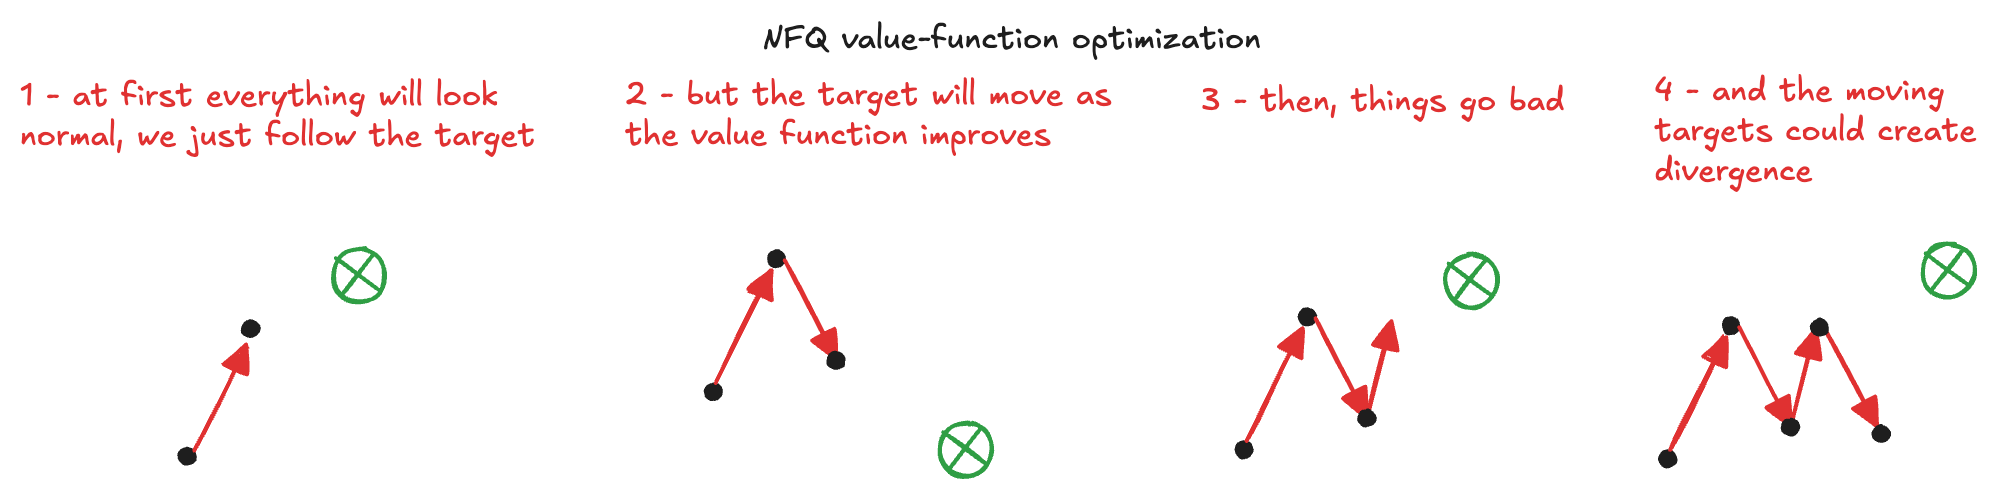

One way to make the target values more stable is by using a separate network that remains fixed for several steps and is dedicated to calculating more consistent targets. This network is known as the **target network**: 

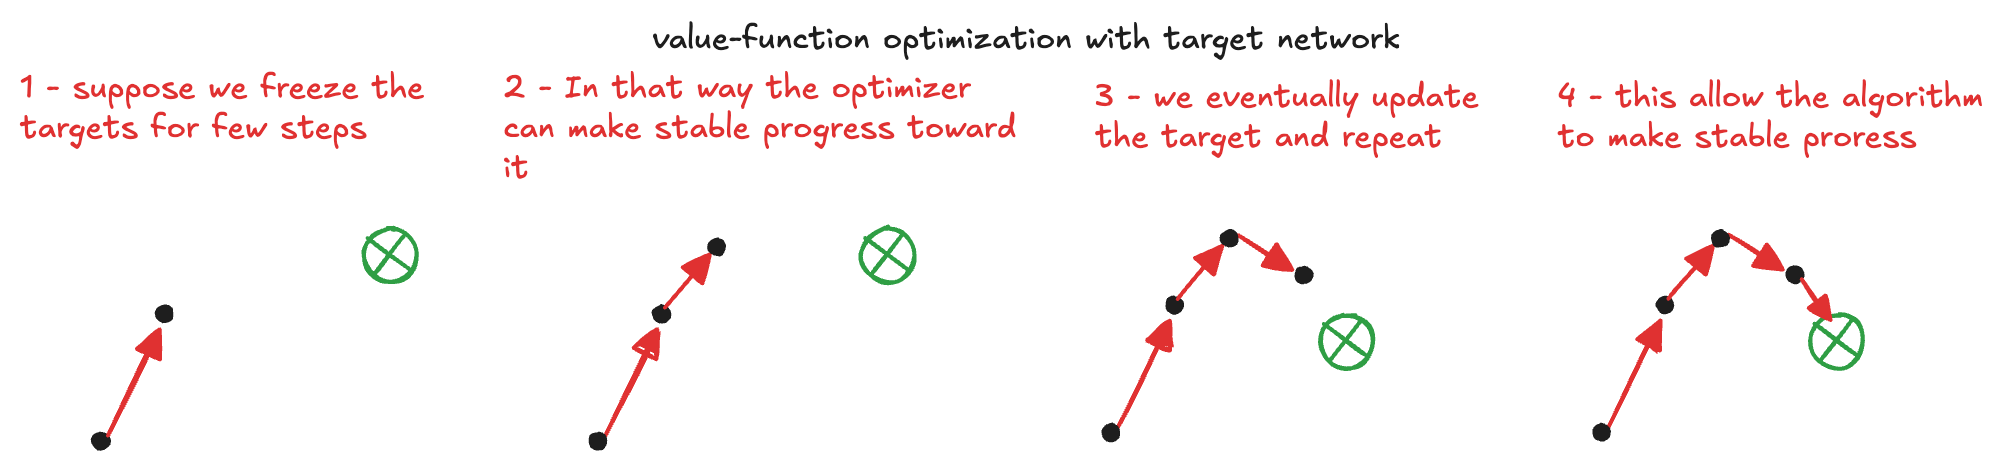

This mitigates the issue of "chasing your own tail" by artificially creating **several small supervised learning problems** presented sequentially to the agent. Targets are fixed for as many steps as we fix our target network. It substantially reduces the chance of divergence. The only difference with NFQ is **the age of the neural network weights**:

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \underset{a}{\text{ max }} Q(s',a;\theta^-) - Q(s,a;\theta))^2 \right]$

Notice that in practice we don’t have two different networks. The target network is a **previous instance of the same neural network** that we freeze for a number of steps. The gradient update now has time to catch up to the target, which is much more stable when frozen. This adds stability to the updates. We use the same model architecture and "sometimes" update the weights of the target network to match the weights of the **online network**, which is the network we optimize on every step. In order to implement this idea, we can use a network architecture identical to the one used in NFQ:

In [119]:
def create_network(input_size, output_size):
    # create a sequential model  
    dnn = torch.nn.Sequential(
          # fully connected layers  
          torch.nn.Linear(input_size[0], 512),  
          torch.nn.ReLU(),                           
          torch.nn.Linear(512, 128),
          torch.nn.ReLU(),
          torch.nn.Linear(128, output_size));
    # return the network  
    return dnn.to(device);

The online network is trained, so we need an optimizer:

In [120]:
def create_optimizer(model, learning_rate):
    optimizer = torch.optim.RMSprop(model.parameters(), 
                                    lr=learning_rate);
    return optimizer;

The target network is not trained, but sometimes we need to **update its weights to match the online network weights**:

In [121]:
def update_target(target_model, online_model):
    # copy the parameters from the online model to the target model
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        target.data.copy_(online.data);

At the end of training, the online network will be used to implement the policy:

In [122]:
def pi(state, model):
    # convert the state into a tensor
    state = np.array(state);
    state = torch.from_numpy(state).unsqueeze(0).to(device);

    # calculate q_values from the network
    q_values = model(state).detach();

    # act greedy
    action = np.argmax(q_values.cpu()).data.numpy();

    # return the action
    return action;

That we can evaluate usgis the average reward over a number of episodes:

In [123]:
def evaluate(env, model, episodes=1):

    # create a list to store the returns for each episode
    returns = [];

    # evaluate the policy for the given number of episodes
    for episode in range(episodes):

        # reset the environment before starting the episode
        state, done = env.reset()[0], False;

        # initialize the return
        returns.append(0);
        
        # interact with the environment until the episode is done
        while not done:

            # select the action using the policy
            action = pi(state, model);
            
            # perform the selected action
            state, reward, terminal, truncated, info = env.step(action)
            
            # add the reward to the return
            returns[-1] += reward;

            # check if the episode is done
            done = terminal or truncated;

    # return the average return        
    return np.mean(returns);

By using the target network, we allow the weights to move consistently toward the targets before an update changes the optimization problem, but we also **slow down learning** because you’re no longer training on up-to-date values. It’s essential to **balance stability and speed** by tuning this hyperparameter. We can modify the optimizing method in order to use the target network to calculate the value of the next state, but the online network to calculate the values of the current state:

In [124]:
def optimize(memory, batch_size, online_model, target_model, optimizer, gamma):

    # sample a batch of experiences
    batch = sample_experiences(memory, batch_size);
    
    # prepare the experience as tensors
    states = torch.from_numpy(batch['state'].copy()).float().to(device);
    actions = torch.from_numpy(batch['action'].copy()).long().to(device);    
    next_states = torch.from_numpy(batch['next_state'].copy()).float().to(device);
    rewards = torch.from_numpy(batch['reward'].copy()).float().to(device);
    failures = torch.from_numpy(batch['failure'].copy()).long().to(device);

    # get the values of the Q-function at next state from the "target" network 
    # remember to detach, we need to treat these values as constants 
    q_target_next = target_model(next_states).detach();
    
    # get the max value 
    max_q_target_next = q_target_next.max(1)[0];

    # one important step, often overlooked, is to ensure 
    # that failure states are grounded to zero
    max_q_target_next *= (1 - failures.float())

    # calculate the target 
    target = rewards + gamma * max_q_target_next;

    # finally, we get the current estimate of Q(s,a)
    # here we query the current "online" network
    q_online_current = torch.gather(online_model(states), 1, actions.unsqueeze(1)).squeeze(1);

    # create the errors
    td_error = target - q_online_current;

    # calculate the loss
    loss = td_error.pow(2).mean();

    # backward pass: compute the gradients
    optimizer.zero_grad();
    loss.backward();

    # update model parameters
    optimizer.step();

We  write also two methods to save and load the model:

In [125]:
def save_model(model, path):
    torch.save(model.state_dict(), path);

def load_model(model, path):
    model.load_state_dict(torch.load(path));
    return model;

## Exploration strategies

Exploration is a crucial aspect of reinforcement learning. In NFQ, we implemented an epsilon-greedy exploration strategy, where the agent acts randomly with a probability of epsilon. However, this is not the only approach (see the notebook on "Exploration vs Exploitation"). Now, we use a **decaying epsilon-greedy strategy**, where we start with a high epsilon value and gradually reduce it over time. This allows the agent to explore the environment more in the early stages of training and increasingly exploit its knowledge as training progresses. While simple and effective, other, more advanced strategies may also be worth exploring. It's important to note that even small changes in hyperparameters can have a significant impact on performance.

In [126]:
def create_epsilons(max, min, decay_steps):

    epsilons = {
        'max': max,
        'min': min,
        'decay_steps': decay_steps,
        'values': np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    };
   
    # normalize the epsilons 
    epsilons['values'] = (epsilons['values'] - epsilons['values'].min()) / (epsilons['values'].max() - epsilons['values'].min());
    
    # scale the epsilons to the desired range
    epsilons['values'] = (max - min) * epsilons['values'] + min;

    return epsilons;

In [127]:
import random

def epsilon_greedy(epsilons, model, state, action_size, step):
    # get the epsilon value    
    epsilon = epsilons['values'][step] if step < epsilons['decay_steps'] else epsilons['min'];

    # select the action using the epsilon-greedy strategy
    if random.uniform(0,1) < epsilon:
        return np.random.randint(action_size);
    else:
        return pi(state, model);

## DQN Algorithm

Deep Q-network (DQN) is one of the most popular deep RL algorithms and it started a series of research innovations that mark the history of RL. DQN claimed for the first time **superhuman level performance** on the [**Atari benchmark**](https://gymnasium.farama.org/environments/atari/) in which agents learned from raw pixel data from mere images ([V. Mnih, et al. **"Playing Atari with Deep Reinforcement Learning"**, NIPS 2013](./papers/2013%20-%20Playing%20Atari%20with%20Deep%20Reinforcement%20Learning.pdf) and [V. Mnih, et al. **"Human-level control through deep reinforcement learning"**, Nature 2015](./papers/2015%20-%20Human-level%20control%20through%20deep%20reinforcement%20learning.pdf)). We now implement the full DQN algorithm, the main difference with NFQ are that is uses a replay buffer, a target network and a deaying epsilon-greedy strategy. The algorithm is as follows:

1. collect experience and insert it into the replay buffer;
2. randomly sample a mini-batch from the buffer and provide it in input to both the online and the target network;
3. use the target network to calculate the Q-values of the next state, but use the online network to calculate the Q-values of the current state;
4. compute the loss function and update the online network;
5. sometimes update the target network with the online network weights.

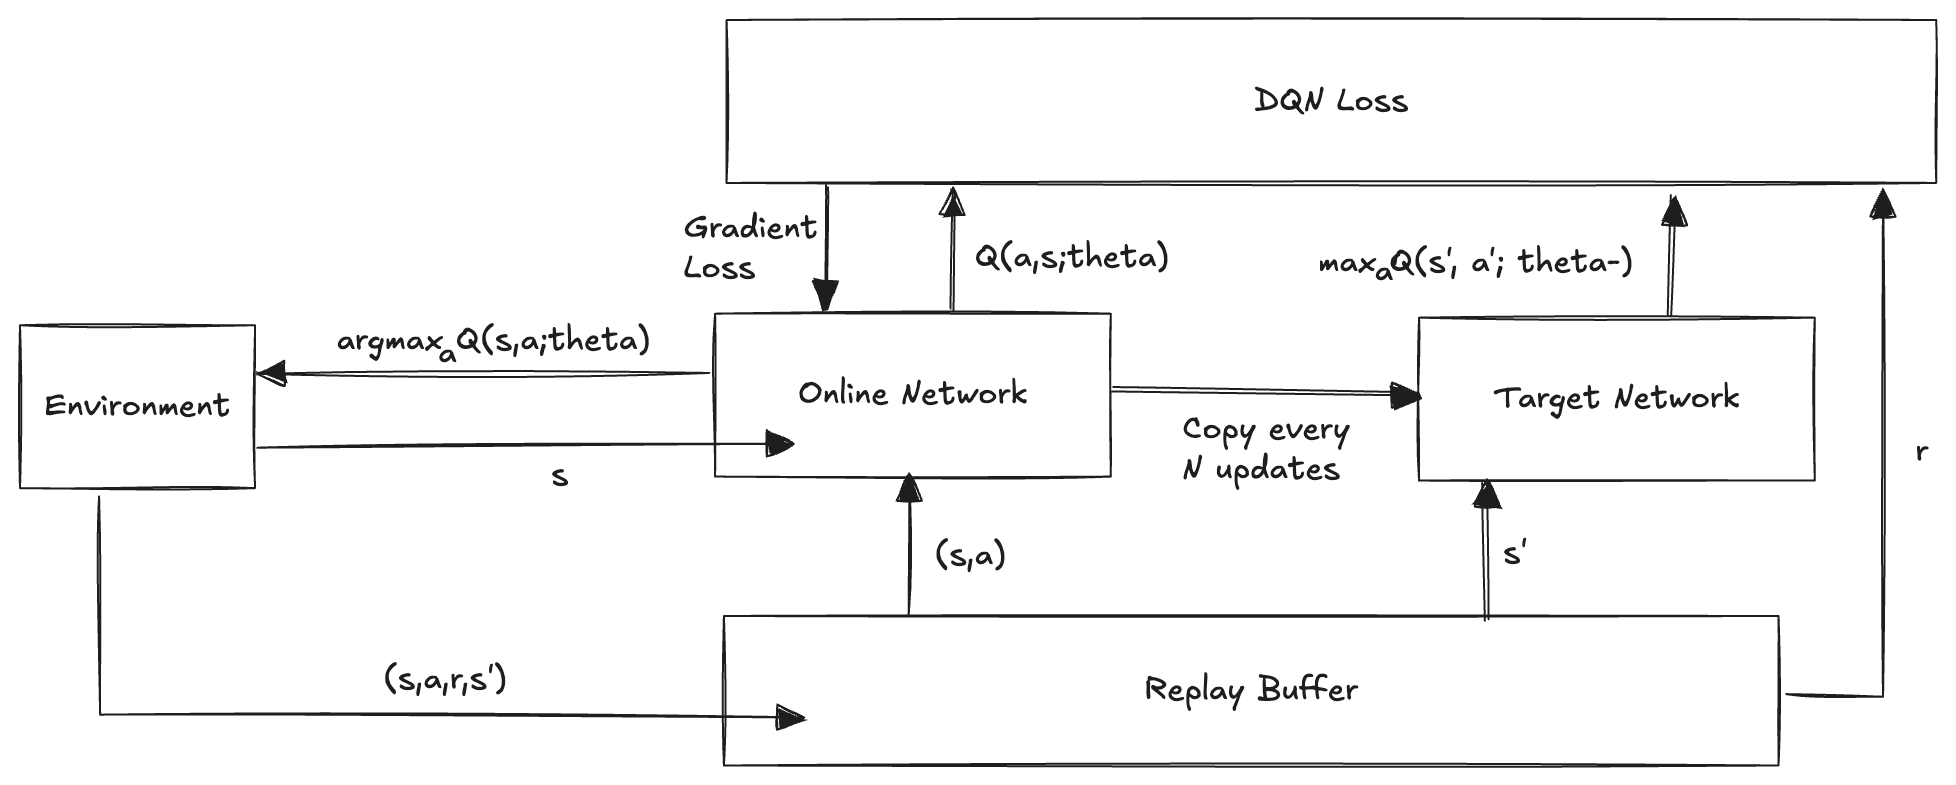

Let's implement the DQN algorithm in Python:

In [128]:
def dqn(env, online_model, target_model, optimizer,
        memory, memory_start_size, batch_size, target_update_steps, 
        epsilons, gamma, max_episodes, model_file_name):
    
    # create a score tracker for statistic purposes
    scores = [];

    # get the action size 
    action_size = env.action_space.n;
    
    # counter for the number of steps 
    step = 0;

    # save the best score and episode obtained so far
    best_score = -1;
    best_episode = -1;

    # update the target model with the online one
    update_target(target_model, online_model);
                   
    # train until for the maximum number of episodes
    for episode in range(max_episodes):
        
        # reset the environment before starting the episode
        state, done = env.reset()[0], False;

        # interact with the environment until the episode is done
        while not done:
                    
            # select the action using the exploration policy
            action = epsilon_greedy(epsilons, online_model, state, action_size, step);

            # perform the selected action
            next_state, reward, terminal, truncated, info = env.step(action);
            done = terminal or truncated;
            failure = terminal and not truncated;

            # store the experience into the replay buffer
            experience = (state, action, reward, next_state, failure);
            store_experience(memory, experience);
    
            # optimize the online model after the replay buffer is large enough
            if memory['entries'] > memory_start_size:
                optimize(memory, batch_size,  online_model, target_model, optimizer, gamma);
                 
                # sometimes, synchronize the target model with the online model
                if step % target_update_steps == 0:
                    update_target(target_model, online_model);
                
            # update current state to next state
            state = next_state;

            # update the step counter
            step += 1;

            # sometime print steps 
            if(step % 10 == 0):
                message = 'Episode {:03}, steps {:04}';
                message = message.format(episode+1, step);
                print(message, end='\r', flush=True);
        
        # After each episode, evaluate the policy
        score = evaluate(env, online_model, episodes=5);

        # in case the score is the best so far, store it
        # and save the model
        if(score > best_score):
            best_score = score;
            best_episode = episode;
            save_model(online_model, model_file_name);

        # store the score in the tracker
        scores.append(score);

        # print some informative logging 
        message = 'Episode {:03}, steps {:04}, current score {:05.1f}, best score {:05.1f} at episode {:03}';
        message = message.format(episode+1, step, score, best_score, best_episode);
        print(message, end='\r', flush=True);
        
    return scores;

We can apply the algorithm to the CartPole environment, where tuning the hyperparameters is critical to optimizing the agent’s performance.

In [129]:
# set the hyperparameters
max_episodes = 500;
memory_size = 100000; 
memory_start_size = 1000;
batch_size = 32; 
gamma = 1.00;
target_update_steps = 100;
epsilon_max = 1.0;
epsilon_min = 0.01;
epsilon_decay_steps = 10000;
learning_rate = 0.001;
model_file_name = '../models/dqn_model.pth';

# get the state and action sizes
state_size = cartpole.observation_space.shape;
action_size = cartpole.action_space.n;

# create the experience type
experience_type = create_type(state_size);

# create the replay memory
memory = create_replay_memory(memory_size, experience_type);

# create the online and target networks
online_model = create_network(state_size, action_size);
target_model = create_network(state_size, action_size);

# create the optimizer
optimizer = create_optimizer(online_model, learning_rate);

# create the epsilon values
epsilons = create_epsilons(epsilon_max, epsilon_min, epsilon_decay_steps);

# run the DQN algorithm
dqn(cartpole, online_model, target_model, optimizer,
    memory, memory_start_size, batch_size, target_update_steps,  
    epsilons, gamma, max_episodes, model_file_name);

From this run, it seems that DQN is much more efficient than NFQ in solving the Cart-pole environment. We can see the agent in action:

In [130]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, model, n_episodes=1, max_steps=500):
    # show the policy for the given number of episodes
    for _ in range(n_episodes):

        # reset the environment
        state = env.reset()[0];

        # reset the done flag and the step counter
        done = False;
        step = 0;

        # interact with the environment until the episode is done
        while not done:

            # select the action using the policy
            action = pi(state, model);

            # perform the selected action
            state, reward, terminated, truncated, info = env.step(action);

            # check if the episode is done  
            if(terminated or truncated): done = True;

            # render the environment
            plt.imshow(env.render());
            plt.show();
            clear_output(wait=True);

            # break if the maximum number of steps is reached
            if step > max_steps: break;

            # update the step counter
            step += 1;  


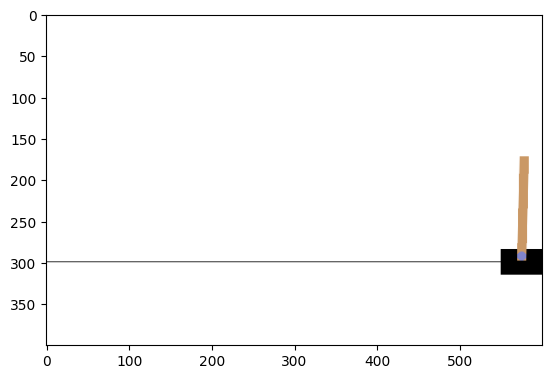

In [131]:
best_model = load_model(online_model, model_file_name);
show_policy(cartpole, best_model, n_episodes=1, max_steps=500);

To compare the performance of the DQN algorithm with that of the NFQ algorithm, we conduct an experiment similar to the one used for NFQ. This allows us to evaluate and compare the performance of both agents effectively.

In [132]:
import joblib

def experiment(env, 
               result_filename, 
               model_file_name,
               max_episodes = 250,
               memory_size = 50000, 
               memory_start_size = 320,
               batch_size = 64, 
               gamma = 1.00,
               target_update_steps = 15,
               epsilon_max = 1.0,
               epsilon_min = 0.3,
               epsilon_decay_steps = 20000,
               learning_rate = 0.0007,
               sliding_windows=25,
               seeds = (12, 34, 56, 78, 90)):


    # variable to collect results
    results = [];

    # get the state and action sizes
    state_size = env.observation_space.shape;
    action_size = env.action_space.n;

    # create the experience type
    experience_type = create_type(state_size);

    # run the experiments for each seed
    for seed in seeds:

        print("Experiment seed: ", seed);

        # set the seeds for reproducibility of results
        torch.manual_seed(seed);
        np.random.seed(seed);
        random.seed(seed);
        env.np_random = np.random.Generator(np.random.PCG64(seed));

        # reset the environment
        env.reset();

        # create online and target models
        online_model = create_network(state_size, action_size);
        target_model = create_network(state_size, action_size);

        # create the optimizer
        optimizer = create_optimizer(online_model, learning_rate);

        # create the replay memory
        memory = create_replay_memory(memory_size, experience_type);

        # create the epsilon values
        epsilons = create_epsilons(epsilon_max, epsilon_min, epsilon_decay_steps);

        # train the network    
        scores = dqn(env, online_model, target_model, optimizer,
                     memory, memory_start_size, batch_size, target_update_steps,  
                     epsilons, gamma, max_episodes, model_file_name);
        
        # smooth the result using a sliding window
        scores = np.convolve(scores, np.ones(sliding_windows)/sliding_windows, mode='valid');
                
        # collect the results
        results.append(scores);

        print("");

    # calculate max, min and average scores among experiments
    max_score = np.max(results, axis=0).T;
    min_score = np.min(results, axis=0).T;
    mean_score = np.mean(results, axis=0).T;

    # prepare the results
    experiment_results = {
        'max_score': max_score,
        'min_score': min_score,
        'mean_score': mean_score,
    }

    # save permanently
    joblib.dump(experiment_results, result_filename);
    
    return experiment_results;

Then we run the experiment for the DQN agent on the cart-pole environment.

In [133]:
dqn_results = experiment(env = cartpole, 
                         result_filename = '../models/dqn_results.joblib', 
                         model_file_name = '../models/dqn_model.pth');

Experiment seed:  12
Episode 250, steps 57535, current score 500.0, best score 500.0 at episode 181
Experiment seed:  34
Episode 250, steps 46142, current score 500.0, best score 500.0 at episode 173
Experiment seed:  56
Episode 250, steps 49510, current score 500.0, best score 500.0 at episode 176
Experiment seed:  78
Episode 250, steps 53433, current score 474.0, best score 500.0 at episode 163
Experiment seed:  90
Episode 250, steps 56614, current score 500.0, best score 500.0 at episode 140


While NFQ's performance fluctuates significantly, DQN demonstrates more consistent results and faster convergence, making it more suitable for this type of environment. It reach high score in a hundred of episodes, while NFQ requires much more episodes to achieve similar results. DQN is more efficient algorithm, and it is the foundation for many other deep RL algorithms. Let's load the results of NFQ in order to compare the performances of the two algorithms:

In [134]:
nfq_results = joblib.load('../models/nfq_results.joblib');

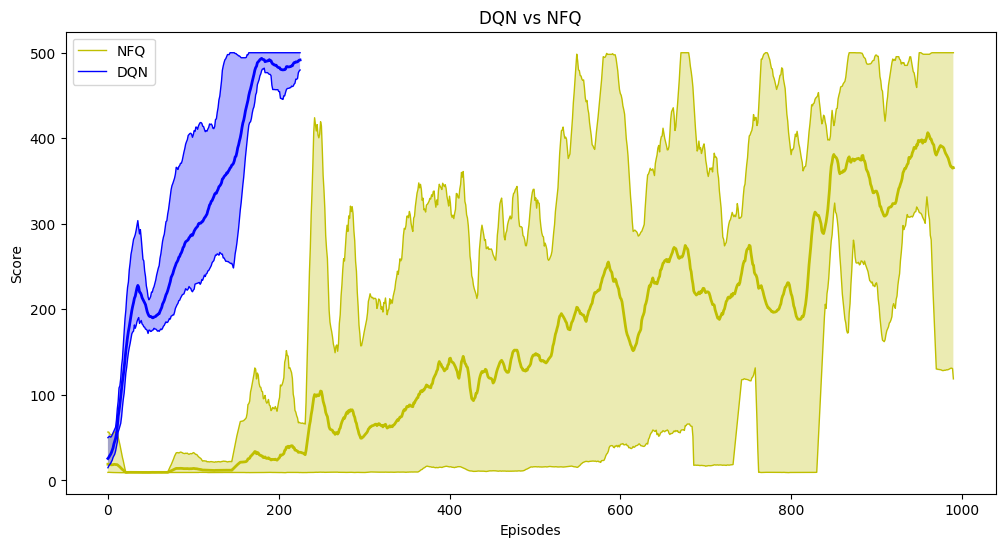

In [135]:
plt.figure(figsize=(12,6));
plt.title('DQN vs NFQ');
plt.ylabel('Score');
plt.xlabel('Episodes');

episodes = range(len(dqn_results['max_score']));
nfq_episodes = range(len(nfq_results['max_score']));

plt.plot(nfq_results['max_score'], 'y', linewidth=1, label="NFQ");
plt.plot(nfq_results['min_score'], 'y', linewidth=1);
plt.plot(nfq_results['mean_score'], 'y', linewidth=2);
plt.fill_between(nfq_episodes, nfq_results['min_score'], nfq_results['max_score'], facecolor='y', alpha=0.3);

plt.plot(dqn_results['max_score'], 'b', linewidth=1, label="DQN");
plt.plot(dqn_results['min_score'], 'b', linewidth=1);
plt.plot(dqn_results['mean_score'], 'b', linewidth=2);
plt.fill_between(episodes, dqn_results['min_score'], dqn_results['max_score'], facecolor='b', alpha=0.3);

plt.legend()
plt.show();

DQN is extrimelly **more powerful and less noisier** than NFQ. Experiment results show that the target network and the replay buffer are important for the stability of the algorithm.

## Double Deep Q-Learning (DDQN)

In general, Q-learning **tends to overestimate action-value functions**, and the DQN agent is no different. We use the same off-policy TD target with the max operator, and taking the max of estimats (which are are often off-center) creates a **positive bias** and performance suffers. One way to better understand this positive bias and how we can address it is by unwrapping the max operator in the target calculations. Notice that the max of a Q-function is the same as the Q-function of the argmax action:

$\displaystyle
\underset{a}{\text{ max }} Q(s',a;\theta^-) = Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta^-);\theta^-)$

so we can modify the loss expression as

$\displaystyle L(\theta) = E_{(s,a) \sim U(D)} \left[ ( r + \gamma \text{ }Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta^-);\theta^-) - Q(s,a;\theta))^2 \right]$

There’s no real difference between the two equations, since both are using the same Q-values for the target. All we’re saying here is that taking the max is like asking the network "What’s the value of the highest-valued action in state s?" But, we are really asking two questions with a single one. First, we do an argmax, which is equivalent to asking, "Which action is the highest-valued action in state s?" and then, we use that action to get its value, equivalent to asking, "What’s the value of this action in state s?" One of the problems is that **we are asking both questions to the same Q-function, which shows bias in the same direction in both answers**. In other words, the function approximator will answer, "I think this one is the highest-valued action in state s, and this is its value". An idea to reduce the chance of positive bias is to have **two instances of the action-value function** ([van Hasselt et al. **"Deep Reinforcement Learning with Double Q-learning"** (2015) AAAI Conference](./papers/2015%20-%20Deep%20Reinforcement%20Learning%20with%20Double%20Q-learning.pdf), so we can ask one of the questions to one and the other question to the other. It’s somewhat like getting a second doctor’s opinion on health matters. In double learning, **one estimator selects the index of what it believes to be the highest-valued action, and the other estimator gives the value of this action**. Implementing this procedure creates **unnecessary overhead** (we end up with four networks, two for training and two target networks) and it creates a **slowdown in the training process** (since we’d be training only one of these networks at a time). Fortunately, there’s a simple modification to the original learning procedure that adapts it to DQN and gives us substantial improvements without the extra overhead: **we can perform double learning with the other network we already have, which is the target network**. We use the online network (the network we’re training) for answering the first question (to find the index of the best action), then we use the target network to ask the second question (evaluate the selected action):

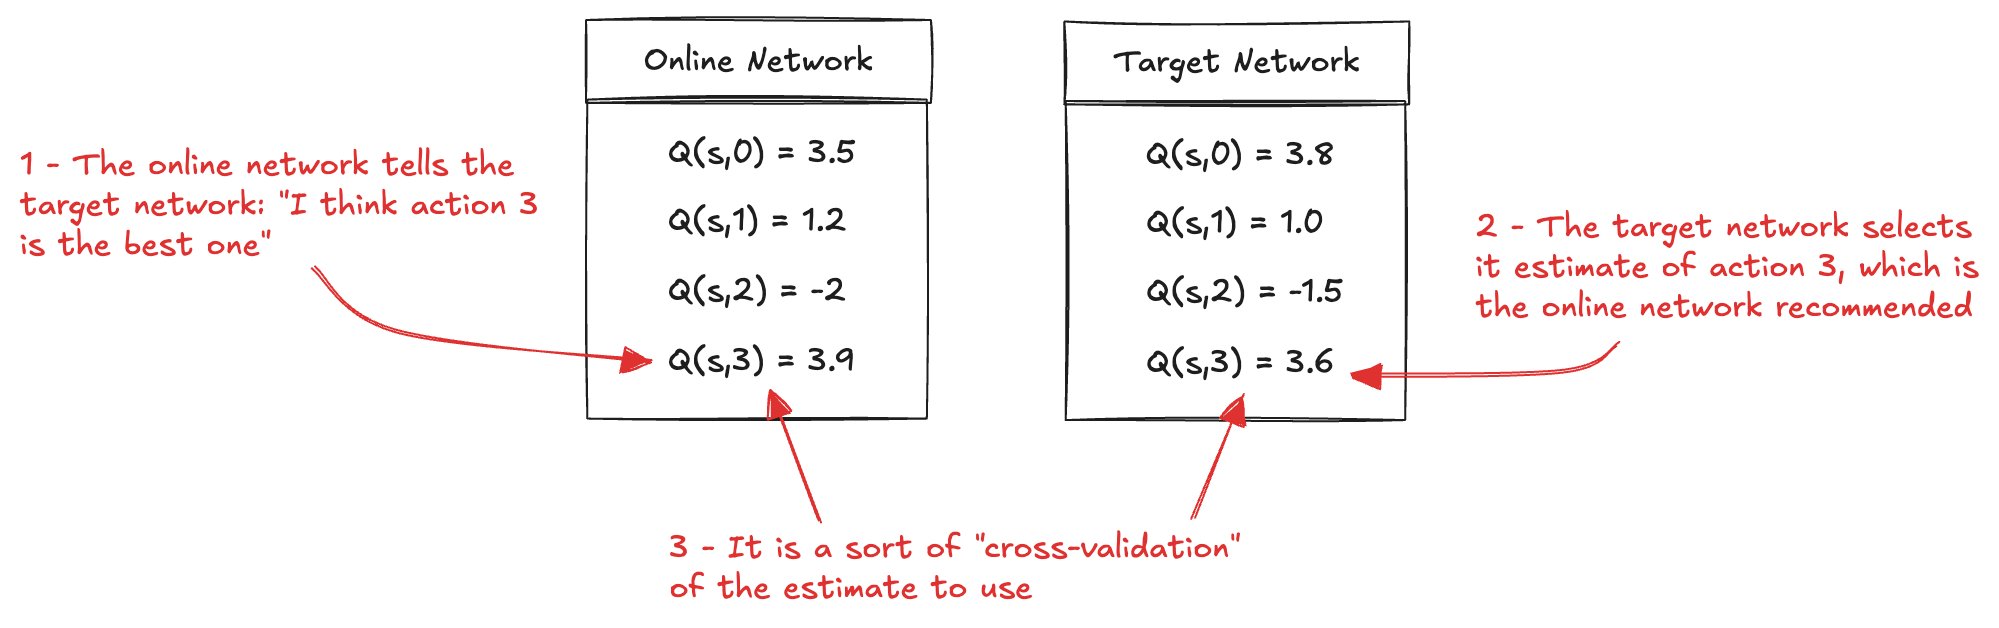

So, the only difference in DDQN is that now we use the online weights to select the action, but still use the frozen weights to get the estimate:

$\displaystyle L(\theta ) =E_{(s,a) \sim U(D)} \left[ ( r + \gamma \text{ } Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta);\theta^-) - Q(s,a;\theta))^2 \right]$

We can rewrite the optimize method in order to implement this idea:

In [136]:
def optimize(memory, batch_size, online_model, target_model, optimizer, gamma):

    # sample a batch of experiences
    batch = sample_experiences(memory, batch_size);

    # prepare the experience as tensors
    states = torch.from_numpy(batch['state'].copy()).float().to(device);
    actions = torch.from_numpy(batch['action'].copy()).long().to(device);    
    next_states = torch.from_numpy(batch['next_state'].copy()).float().to(device);
    rewards = torch.from_numpy(batch['reward'].copy()).float().to(device);
    failures = torch.from_numpy(batch['failure'].copy()).long().to(device);
    
    # get the online model and target model predictions for the next state
    # remember to detach because this part is fixed and should not be part 
    # of the gradient calculation
    q_online_next = online_model(next_states).detach();
    q_target_next = target_model(next_states).detach();

    # get the best actions according to the online model
    best_actions = q_online_next.max(1)[1];

    # get the value estimations of the best actions from the target model
    max_q_target_next = torch.gather(q_target_next, 1, best_actions.unsqueeze(1)).squeeze(1);
    max_q_target_next = max_q_target_next * (1 - failures.float());

    # calculate the target 
    target = rewards + gamma * max_q_target_next;

    # finally, we get the current estimate of Q(s,a)
    # here we query the current "online" network
    q_online_current = torch.gather(online_model(states), 1, actions.unsqueeze(1)).squeeze(1);

    # create the errors
    td_error = target - q_online_current;

    # calculate the loss
    loss = td_error.pow(2).mean();

    # backward pass: compute the gradients
    optimizer.zero_grad();
    loss.backward();

    # update model parameters
    optimizer.step();

We run the experiment in order to evaluate the impact of this idea:

In [137]:
ddqn_results = experiment(env = cartpole, 
                         result_filename = '../models/ddqn_results.joblib', 
                         model_file_name = '../models/ddqn_model.pth',
                         learning_rate = 0.001);

Experiment seed:  12
Episode 250, steps 56154, current score 462.6, best score 500.0 at episode 165
Experiment seed:  34
Episode 250, steps 48869, current score 500.0, best score 500.0 at episode 192
Experiment seed:  56
Episode 250, steps 52294, current score 500.0, best score 500.0 at episode 135
Experiment seed:  78
Episode 250, steps 50042, current score 500.0, best score 500.0 at episode 016
Experiment seed:  90
Episode 250, steps 59118, current score 500.0, best score 500.0 at episode 138


After the esperiment, we save results for later use and we make similar statistical operations to create a graph of performance:

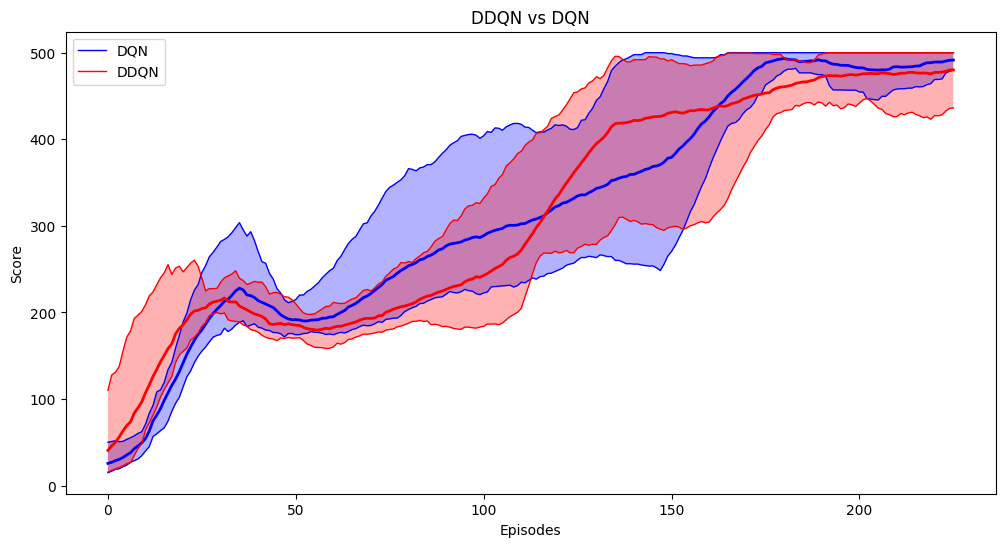

In [138]:
plt.figure(figsize=(12,6));
plt.title('DDQN vs DQN');
plt.ylabel('Score');
plt.xlabel('Episodes');

plt.plot(dqn_results['max_score'], 'b', linewidth=1, label="DQN");
plt.plot(dqn_results['min_score'], 'b', linewidth=1);
plt.plot(dqn_results['mean_score'], 'b', linewidth=2);
plt.fill_between(episodes, dqn_results['min_score'], dqn_results['max_score'], facecolor='b', alpha=0.3);

plt.plot(ddqn_results['max_score'], 'r', linewidth=1, label="DDQN");
plt.plot(ddqn_results['min_score'], 'r', linewidth=1);
plt.plot(ddqn_results['mean_score'], 'r', linewidth=2);
plt.fill_between(episodes, ddqn_results['min_score'], ddqn_results['max_score'], facecolor='r', alpha=0.3);

plt.legend();
plt.show();


DQN and DDQN have similar performance in the cart-pole environment. DDQN seems **slightly more data efficient** since the number of samples it needs to pass the environment is lower than that of the DQN. However, this is a simple environment with a smooth reward function. In reality, DDQN should always give better performance than DQN in a more evident way.

## Prioritized Experience Replay (PER)

The agent samples experience tuples from replay memory uniformly at random. Intuitively, this seems like an **inefficient way to replay experiences**. It feels wasteful for the agent to spend time "learning" from experiences that offer little relevance to its current state. While this issue is clear, it’s more challenging to define a better sampling strategy. One might think that, since the agent aims to maximize cumulative discounted rewards, it should focus on replaying experiences with high rewards. However, this approach proved ineffective. The agent also needs other types of experiences! What we’re really looking for are **experiences with unexpected value (surprising experiences)**. The agent forms expectations about the world, and when outcomes deviate significantly from these expectations, it presents a key learning opportunity. In reinforcement learning, this **measure of surprise** is captured by the TD error, which quantifies the difference between the agent’s current estimate and the target value. The greater this difference, the more unexpected the experience is, making it a valuable opportunity for the agent to learn and adjust its understanding ([Tom Schaul et al. **Prioritized Experience Replay** ICLR 2016](./papers/2016%20-%20Prioritized%20Experience%20Replay.pdf)):

$\displaystyle |\delta| = |r + \gamma \text{ } Q(s', \underset{a}{\text{argmax }}\text{ } Q(s',a;\theta );\theta^-)-Q(s,a;\theta)$

We can  **insert experience into the replay memory as a tuple containing also to the TD error**, so we can pull out the top experiences from the buffer **sorting** by this new value. However there two issues with this approach. First, we are calculating the TD errors twice (before inserting it into the memory, and then again when we train the network), second we’re ignoring the fact that TD errors change every time the network changes, because they’re calculated using the network (bootstrapping). The solution can’t be updating all of the TD errors every time step, it’s simply not cost effective. A workaround for both these problems is to **update the TD errors only for experiences that are used to update the network (the replayed experiences)** and insert new experiences with the highest magnitude TD error in the memory. However, other issues arise: a TD error of zero in the first update means that experience will likely never be replayed again, moreover when using function approximator, errors shrink slowly, and this means that updates concentrate heavily in a small subset of the replay memory. For these reasons, we need a strategy for sampling experiences based on the TD errors, but **stochastically, not greedily**: in that way we can simultaneously ensure all experiences have a chance of being replayed, and that the probabilities of sampling experiences are monotonic in the absolute TD error. So, first we calculate priorities for each sample in the buffer based on TD errors adding a small constant (epsilon) to make sure zero TD error samples still have a chance of being replayed:

$\displaystyle p_i = |\delta_i| + \epsilon$

Then, we scale the priority by exponentiating it to a hyperparameter alfa that allows us to interpolate between uniform and prioritized sampling:

$\displaystyle P(i)=\frac{p_i^\alpha}{\sum\limits_{k}{p_k^\alpha} }$

When alpha is zero, all priorities are treated equally, resulting in uniform sampling. When alpha is one, the priorities directly correspond to the absolute TD error values. Intermediate values of alpha blend these two strategies, balancing between uniform sampling and prioritization. The scaled priorities are converted to actual probabilities by dividing by the sum of the values. 


One issue with this approach is its sensitivity to outliers. Experiences with unusually high TD errors (whether due to noise or actual significance) are sampled more frequently than those with lower errors. This can lead to over-sampling such outliers, which may be undesirable. So prioritization introduces **sampling bias toward high-priority experiences**, meaning those with high TD errors are more likely to be selected, deviating from uniform sampling. Over-sampling high-priority experiences without adjustment can cause the model to overfit to these specific cases. To address this, we need to compensate for the bias during training. While **we want important experiences to be sampled more often, we must also reduce their impact by giving them lower weight during training**. This is done using **weighted importance sampling**, where the TD errors are scaled by weights based on the sampling probabilities:


$\displaystyle w_i = \left(\frac{1}{N} \frac{1}{P_i}\right)^\beta$


We introduce the beta hyperparameter to control the degree of bias correction. When 
beta is zero, no correction is applied, while a value of one fully corrects the sampling bias. Early in training, when learning is highly unstable, the corrections are less critical. However, as training progresses, the importance of these corrections increases. To accommodate this, beta typically starts with a smaller value (commonly between 0.4 and 0.6) and gradually anneals toward one as training nears completion. Additionally, we normalize the importance-sampling weights by dividing them by the maximum weight, ensuring that the largest weight is one and all others scale proportionally. This normalization prevents the TD errors from growing too large, helping to maintain stability throughout training:

$\displaystyle w_i = \frac{w_i}{\text{max }(w_j)}$

We modify the definition of replay memory in order to add the priority value to all sample and the parameters for the sampling algorithm:

In [139]:
# add the priority filed to the experience type
def create_type(state_size):
    experience_type = np.dtype([
        ('state', np.float32, (state_size)), 
        ('action', np.int8),                  
        ('reward', np.float32),               
        ('next_state', np.float32, (state_size)),  
        ('failure', np.int8),
        ('priority', np.float32),
        ('weight', np.float32)                
    ])
    return experience_type;

We modify the store method in order to initialize the priority of samples:

In [140]:
def store_experience(memory, experience):

    # calculate the priority for the sample using the highest magnitude 
    # TD error in the memory
    priority = 1.0
    if memory['entries'] > 0:
        priority = memory['buffer'][:memory['entries']]['priority'].max()
    
    # intialize the weight to 1
    weight = 1.0;

    # add the priority and weight fields to the experience
    experience = experience + (priority,);
    experience = experience + (weight,);
    
    # store the experience in the buffer
    memory['buffer'][memory['index']] = experience;
    
    # update the number of experiences in the buffer
    memory['entries'] = min(memory['entries'] + 1, memory['size']);

    # update index, if the memory is full, start from the begging 
    memory['index'] += 1;
    memory['index'] = memory['index'] % memory['size'];

We need a method to update the priority of samples that are used to update the network (the replayed experiences):

In [141]:
def update_experience(memory, idxs, td_errors):
    # takes the array of experiences ids, and new TD error values
    # insert the absolute TD errors into the right place.
    memory['buffer'][idxs]['priority'] = np.abs(td_errors);

Finally, we change the sample method in order to implement the prioritized sampling:

In [142]:
def sample_experiences(memory, batch_size):

    # hyperparameters for the prioritized experience replay
    alpha = 0.5;
    beta = 0.4;
      
    # go from priorities to probabilities
    priorities = memory['buffer'][:memory['entries']]['priority'] + 1e-6;
    scaled_priorities = priorities ** alpha;              

    probs = scaled_priorities / np.sum(scaled_priorities);
    
    # calculate the importance-sampling weights using the probabilities
    weights = (memory['entries'] * probs) ** beta;
    weights = weights/weights.max();

    # store the weights in the buffer
    memory['buffer'][:memory['entries']]['weight'] = weights;

    # sample experiences in the memory using the probabilities
    idxs = np.random.choice(memory['entries'], batch_size, replace=False, p=probs);

    # return the batch of experiences
    experiences = memory['buffer'][idxs];

    return experiences, idxs;

Now we can write the new expression for the loss function. First of all we are sampling from the replay buffer using the probabilities calculated by the priorities (P) and not uniformly at random (U).  Moreover we use the importance-sampling weights to scale the TD errors:

$\displaystyle L(\theta)=E_{(s,a) \sim P(D)} \left[ w ( r + \gamma \text{ } Q(s',\underset{a}{\text{argmax }} Q(s',a;\theta);\theta^-) - Q(s,a;\theta))^2 \right]$

We can implement this loss function in the optimize method:

In [143]:
def optimize(memory, batch_size, online_model, target_model, optimizer, gamma):

    # sample a batch of experiences
    batch, idxs = sample_experiences(memory, batch_size);

    # prepare the experience as tensors
    states = torch.from_numpy(batch['state'].copy()).float().to(device);
    actions = torch.from_numpy(batch['action'].copy()).long().to(device);    
    next_states = torch.from_numpy(batch['next_state'].copy()).float().to(device);
    rewards = torch.from_numpy(batch['reward'].copy()).float().to(device);
    failures = torch.from_numpy(batch['failure'].copy()).long().to(device);
    priorities = torch.from_numpy(batch['priority'].copy()).float().to(device);
    weights = torch.from_numpy(batch['weight'].copy()).float().to(device);
        
    # get the online model and target model predictions for the next state
    # remember to detach because this part is fixed and should not be part 
    # of the gradient calculation
    q_online_next = online_model(next_states).detach();
    q_target_next = target_model(next_states).detach();

    # get the best actions according to the online model
    best_actions = q_online_next.max(1)[1];

    # get the value estimations of the best actions from the target model    
    max_q_target_next = torch.gather(q_target_next, 1, best_actions.unsqueeze(1)).squeeze(1);
    max_q_target_next = max_q_target_next * (1 - failures.float());

    # calculate the target 
    target = rewards + gamma * max_q_target_next;

    # finally, we get the current estimate of Q(s,a)
    # here we query the current "online" network
    q_online_current = torch.gather(online_model(states), 1, actions.unsqueeze(1)).squeeze(1);

    # create the errors
    td_errors = target - q_online_current;

    # calculate the loss using the TD error downscaled by the weights
    loss = (weights * td_errors).pow(2).mean();

    # backward pass: compute the gradients
    optimizer.zero_grad();
    loss.backward();

    # update model parameters
    optimizer.step();

    # update the priorities of the replayed batch 
    # using the absolute TD errors
    priorities = np.abs(td_errors.detach().cpu().numpy());
    update_experience(memory, idxs, priorities.squeeze());

We run the experiment in order to evaluate the impact of this idea:

In [144]:
per_results = experiment(env = cartpole, 
                               result_filename = '../models/per_results.joblib', 
                               model_file_name = '../models/per_model.pth',
                               learning_rate = 0.001);

Experiment seed:  12
Episode 250, steps 68056, current score 500.0, best score 500.0 at episode 112
Experiment seed:  34
Episode 250, steps 48584, current score 369.8, best score 500.0 at episode 170
Experiment seed:  56
Episode 250, steps 54747, current score 458.2, best score 500.0 at episode 140
Experiment seed:  78
Episode 250, steps 55887, current score 479.0, best score 500.0 at episode 149
Experiment seed:  90
Episode 250, steps 60968, current score 500.0, best score 500.0 at episode 150


After the esperiment, we save results for later use and we make similar statistical operations to create a graph of performance:

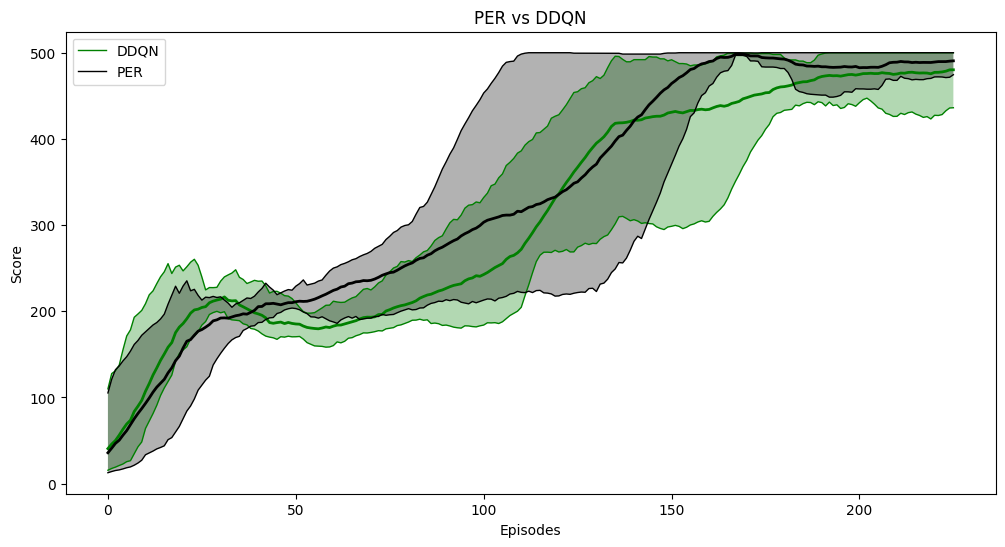

In [ ]:
plt.figure(figsize=(12,6));
plt.title('PER vs DDQN');
plt.ylabel('Score');
plt.xlabel('Episodes');

plt.plot(ddqn_results['max_score'], 'g', linewidth=1, label="DDQN");
plt.plot(ddqn_results['min_score'], 'g', linewidth=1);
plt.plot(ddqn_results['mean_score'], 'g', linewidth=2);
plt.fill_between(episodes, ddqn_results['min_score'], ddqn_results['max_score'], facecolor='g', alpha=0.3);

plt.plot(per_results['max_score'], 'k', linewidth=1, label="PER");
plt.plot(per_results['min_score'], 'k', linewidth=1);
plt.plot(per_results['mean_score'], 'k', linewidth=2);
plt.fill_between(episodes, per_results['min_score'], per_results['max_score'], facecolor='k', alpha=0.3);

plt.legend();
plt.show();

The prioritized replay buffer uses fewer samples than any of the previous methods. And as you can see it in the graphs below, it even makes things look more stable. PER is much slower than other methods, but this is an implementation-specific issue, if we get a high quality implementation of the replay buffer, this shouldn’t happen.

## Dueling Architecture

The dueling network is an improvement that applies to the network architecture and not the algorithm. Until now, we concentrated our efforts on making reinforcement learning **looks more like a supervised learning problem**: using the replay memory we made data more like an independent and identically distributed dataset, using two networks we made targets look more static. This helps stabilize training, but ignoring the fact that reinforcement learning problems are problems of their own isn’t the smartest approach to solving these problems. Now we try to exploit the subtleties of value-based deep reinforcement learning agents, in particular the way the value functions relate to one another. More specifically, we can use the fact that the state-value function and the action-value function are related to each other through the **aadvantage-value function**:

$\displaystyle v_{\pi}(s) = E_{\pi}[G_t | S_t=s]$

$\displaystyle q_{\pi}(s,a) = E_{\pi}[G_t | S_t=s, A_t=a]$

we can define the **advantage-value function** as the **difference between the value of taking an action in a state and the value of choosing the policy action**:

$\displaystyle a_{\pi}(s,a) = q_{\pi}(s,a) - v_{\pi}(s)$

Considering the following example from cart-pole to better understand the idea of the advantage-value function:

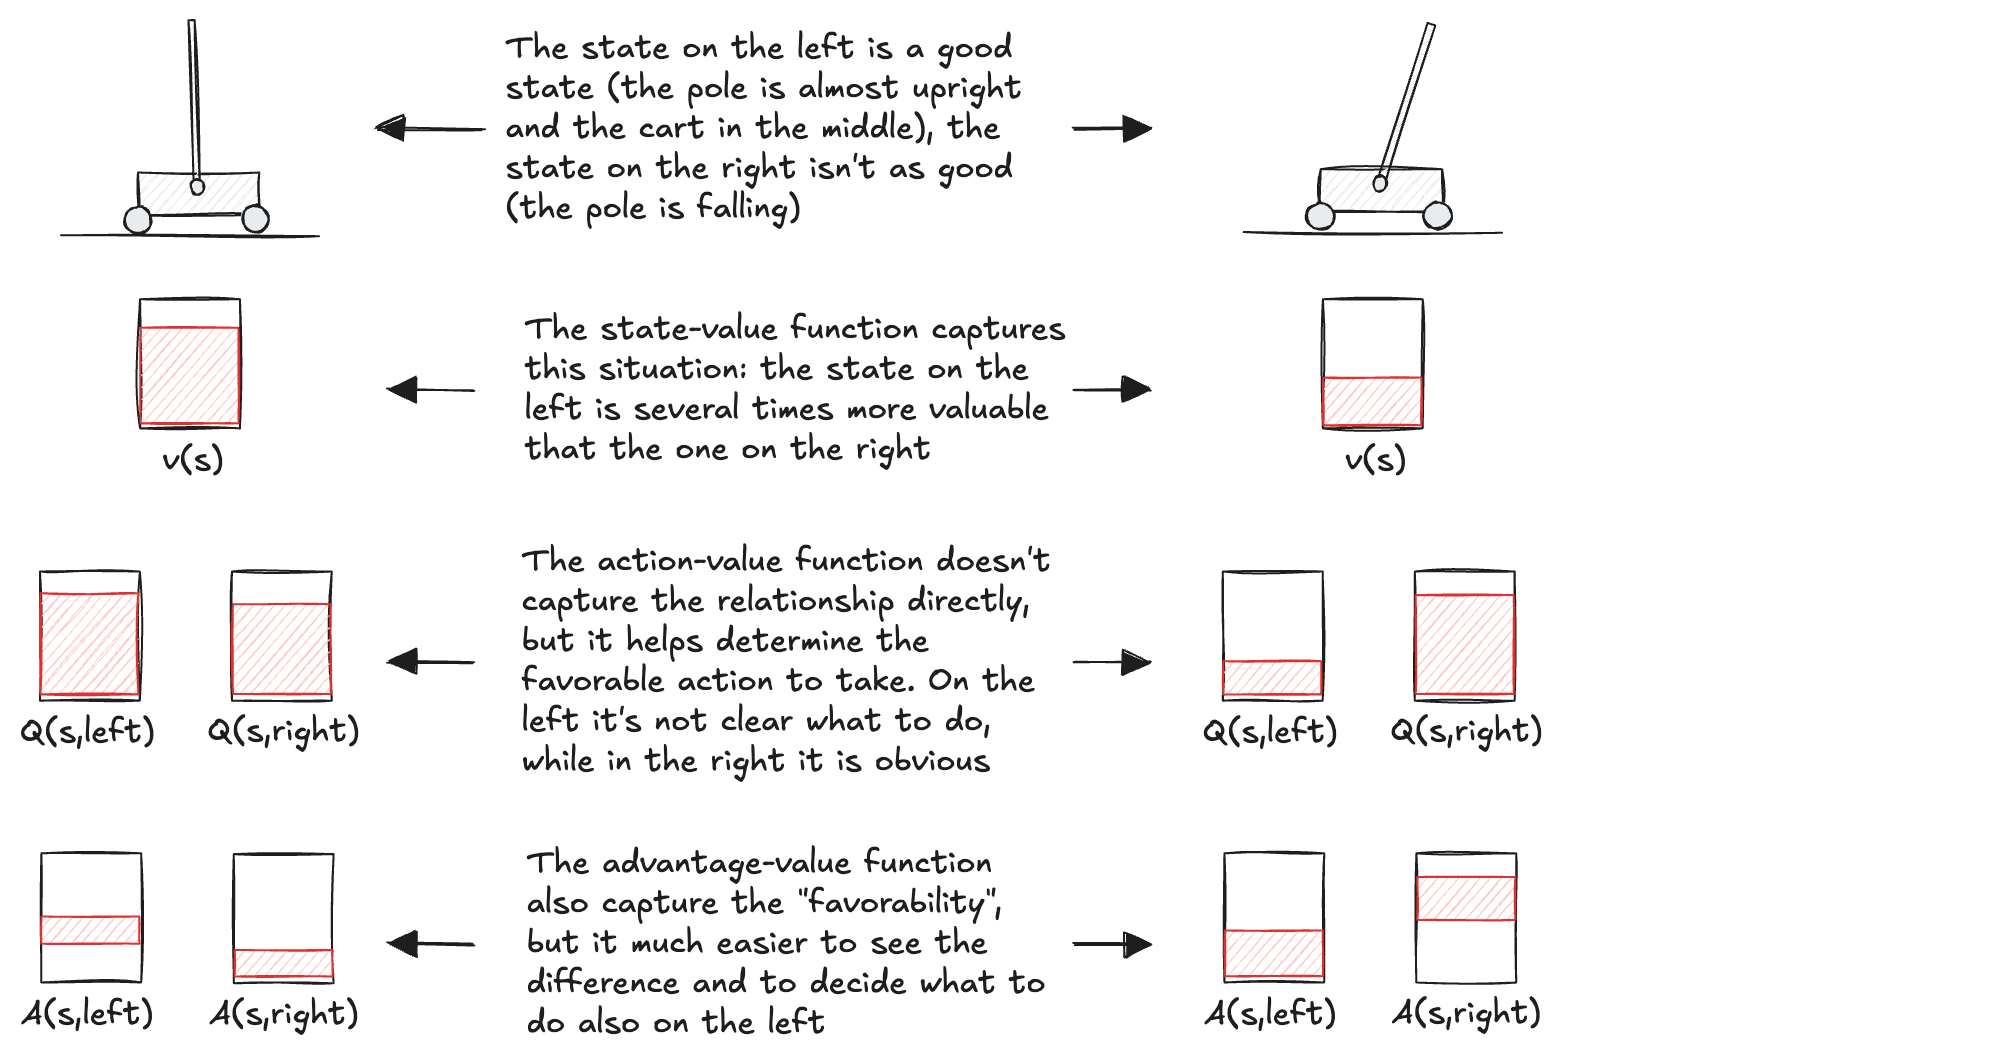

We can rewrite the equation and observe that the action-value function can be defined as the sum of the state-value function and the advantage-value function. This means that we can decompose the action-value function into two components: **one shared across all actions (state-value), and another unique to each action (advantage-value)**:

$\displaystyle q_{\pi}(s,a) = v_{\pi}(s) + a_{\pi}(s,a)$

This means that we’re learning the action-value function inefficiently, because **some information is shared between the nodes of a network**. However, when learning about the action-value of an action, we’re ignoring the fact that we could use the same information to learn something about all other actions:

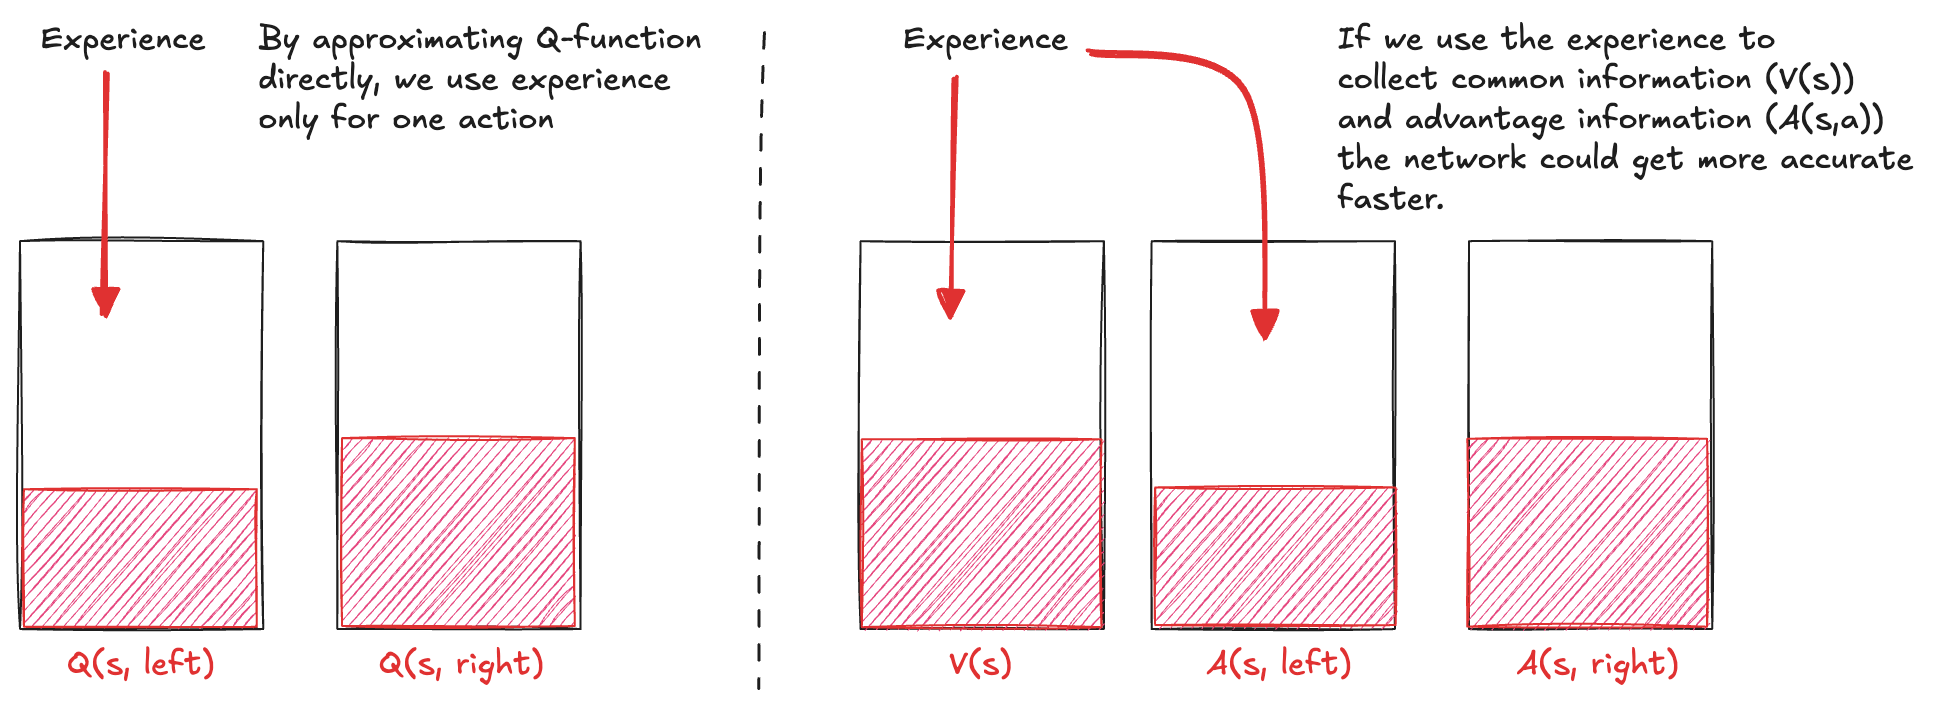

The bottom line is that **the values of actions depend on the values of states**, and it would be nice to leverage this fact. The **Dueling Network Architecture** ([Ziyu et al. **Dueling Network Architectures for Deep Reinforcement Learning**, ICML 2016](./papers/2016%20-%20Dueling%20Network%20Architectures%20for%20Deep%20Reinforcement%20Learning.pdf)) consists of creating two separate estimators: one of the state-value function, and the other of the action-advantage function. We can use a single network sharing most of the internal nodes and layers, the layer before the output splits into two heads: an head for the state-value function and another head for the action-advantage function. The state-value function output layer always ends in a single node because the value of a state is always a single number, the output layer for the advantage-value function, however, outputs a vector of the same size as the number of actions:

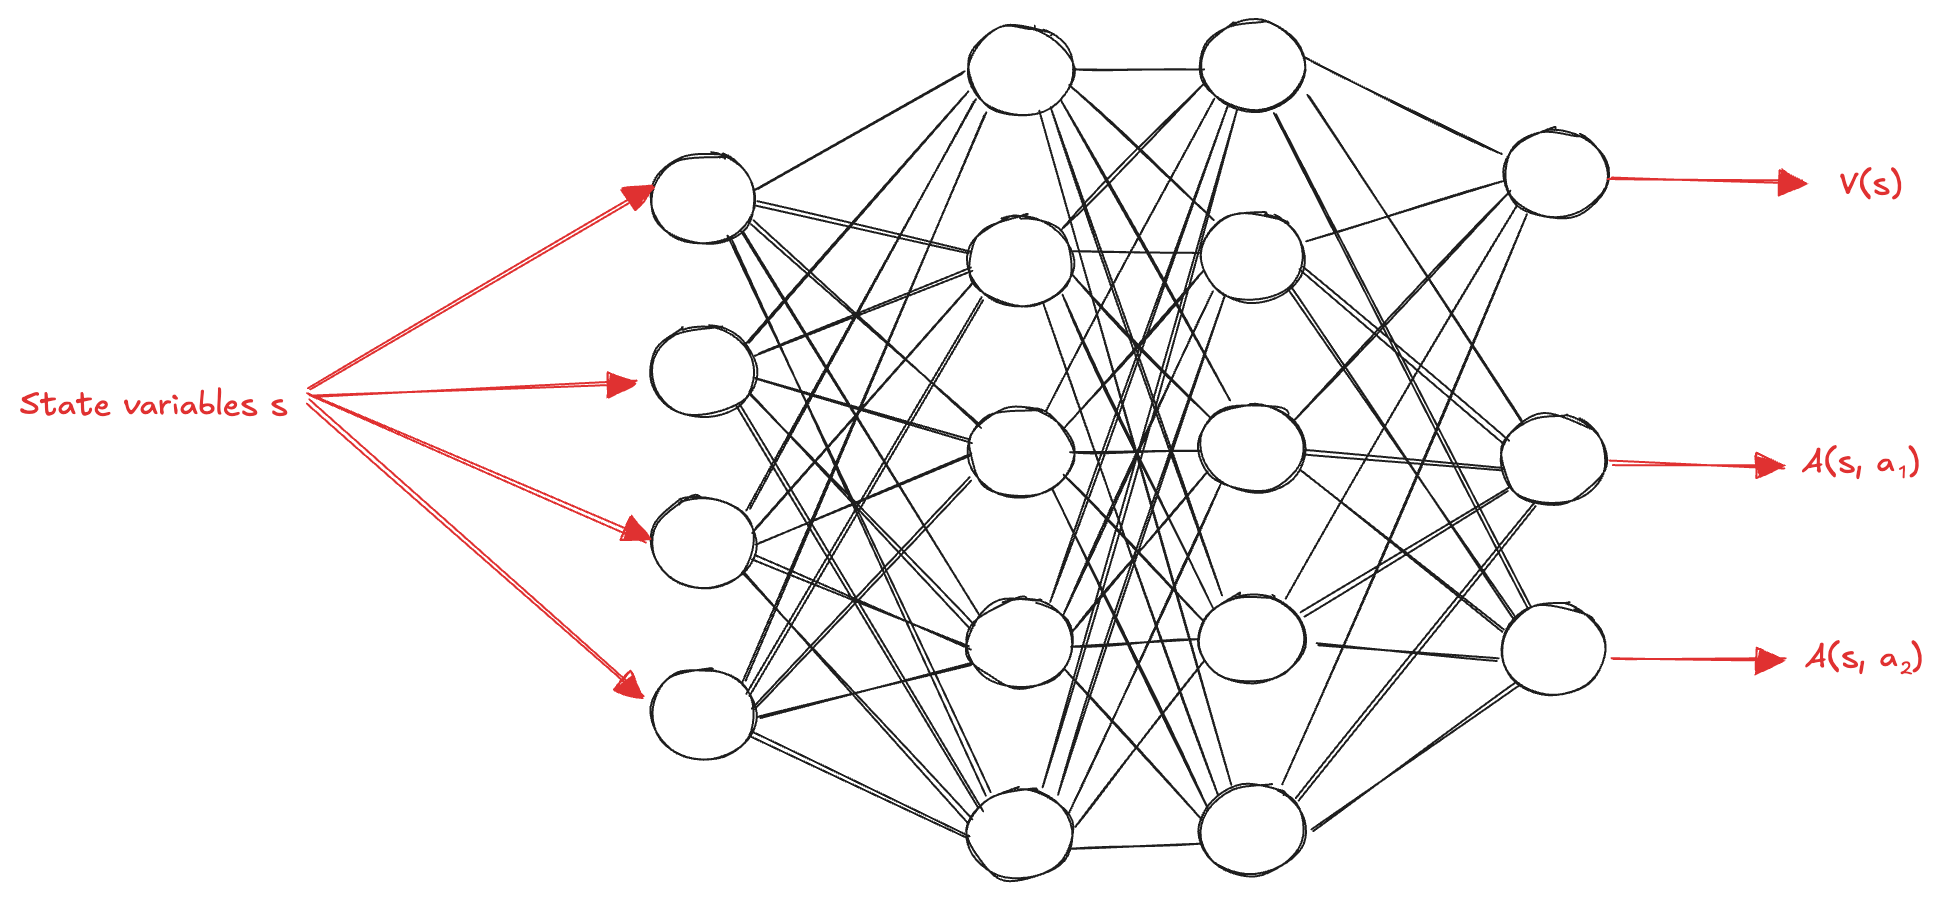

Now, we need to find a way to **aggregate the two outputs from the network** and reconstruct the action-value function. How do we join the outputs? Unfortunately, we cannot simply compute the sum directly. Consider the Q-function, it is parameterized by weights of the shared layers (theta), weights of the advantage-value function head (alpha)), and weights of the state-value function head (beta):

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha)$

Notice that we cannot uniquely recover the Q from V and A. Imagine a situation where all actions in a given state should have the same Q-value. The value of V can remain constant, and the algorithm can arbitrarily increase or decrease the advantage for different actions. This introduces ambiguity because it falsely suggests one action is better or worse, even though they should have equal value. This confuses the learning process by decoupling the real relation between the state value and the advantage value. To avoid ambiguity, the mean of the advantage should be subtracted, enduring that V represents only the state's importance, while A models the **relative differences** between actions.. This normalization prevents the network from skewing the advantage values incorrectly:

$\displaystyle Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \left( A(s,a;\theta,\alpha) - \frac{1}{|A|}\sum\limits_{a'}{A(s,a;\theta,\alpha)} \right)$

We implement the dueling network architecture in Python, however we cannot use the Sequential class of PyTorch, since we need to split the network into two heads, one to evaluate A and one to evaluate V. So we need to implement a custom architecture:

In [ ]:
class DualHeadNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(DualHeadNetwork, self).__init__()
        
        # shared layers 
        self.shared = torch.nn.Sequential(
            torch.nn.Linear(input_size[0], 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU());
        
        # value head
        self.v_head = torch.nn.Linear(128, 1);

        # advantage head
        self.advantage_head = torch.nn.Linear(128, output_size);
    
    def forward(self, state):
        x = self.shared(state);
        a = self.advantage_head(x);
        v = self.v_head(x).expand_as(a);
        #q = v + (a - a.mean(1, keepdim=True).expand_as(a));
        q = v + a;
        return q;

Now we can create the online and target networks using the dueling architecture:

In [ ]:
def create_network(input_size, output_size):
    dnn = DualHeadNetwork(input_size, output_size);
    return dnn.to(device);

The rest of the architecture of the Dueling DDQN is almost identical to DDQN: the network outputs the action-value approximation, an off-policy TD target is used to evaluate policies, a replay memory is used to learning from past experiences, the optimizer is the RMSprop, an exponentially decaying epsilon-greedy strategy is used to improve policies and a greedy action selection strategy for the evaluation step. However we can observe that the DDQN agent use a target network that can be **outdated for several steps** before it gets a weight update. There are a couple of issues with this approach: on the one hand, we’re freezing the weights for several steps and calculating estimates with progressively increasing stale data, on the other hand, a huge update is made to the network, that changes the whole landscape of the loss function all at once. **This update style seems to be both too conservative and too aggressive at the same time**. Of course, we got into this issue because we wanted our network not to move too quickly and therefore create instabilities. We can have similar results, but in a smooth manner: we can **slow down the target network instead of freezing it**. This technique is called **Polyak Averaging**, and it consists of mixing online network weights into the target network on every step. We create a new target network composed of a large percentage of the target network weights and a small percentage of the online network weights. In that way, the target network always lags, but by a much smaller gap. So, instead of making the target network equal to the online network every N time steps, we mix the target network with a tiny bit of the online network more frequently (even every time step):

$\displaystyle \theta_i^- = \tau \theta_i + (1-\tau)\theta_i^-$

$\displaystyle \alpha^- = \tau \alpha_i + (1-\tau)\alpha_i^-$

$\displaystyle \beta_i^- = \tau \beta_i + (1-\tau)\beta_i^-$

where $\tau$ is the **mixing factor**. We can modify the update function in order to implement this idea:

In [ ]:
def update_target(target_model, online_model, tau=0.1):  
        
    for target, online in zip(target_model.parameters(), online_model.parameters()):
        # calculate the ratios we’re taking from the target and online weights
        target_ratio =  tau * target.data;
        online_ratio = (1.0 - tau) * online.data;
        
        # mix the weights and copy the new values into the target network 
        mixed_weights = target_ratio + online_ratio;
        target.data.copy_(mixed_weights);

We can perform the experiment using the dueling improvements, setting the tau parameter at 0.01 and the target_update_steps to 1, the target network will be fully updated every 100 steps, as in our previous experiments, but this time more gradually and smoothly:

In [ ]:
dueling_dqn_results = experiment(env = cartpole, 
                                 result_filename = '../models/dueling_dqn_results.joblib', 
                                 model_file_name = '../models/dueling_dqn_model.pth',
                                 target_update_steps = 1);

Experiment seed:  12
Episode 250, steps 46083, current score 500.0, best score 500.0 at episode 117
Experiment seed:  34
Episode 250, steps 44098, current score 487.6, best score 500.0 at episode 214
Experiment seed:  56
Episode 250, steps 55345, current score 500.0, best score 500.0 at episode 103
Experiment seed:  78
Episode 250, steps 32102, current score 468.4, best score 500.0 at episode 245
Experiment seed:  90
Episode 250, steps 54391, current score 404.2, best score 500.0 at episode 074


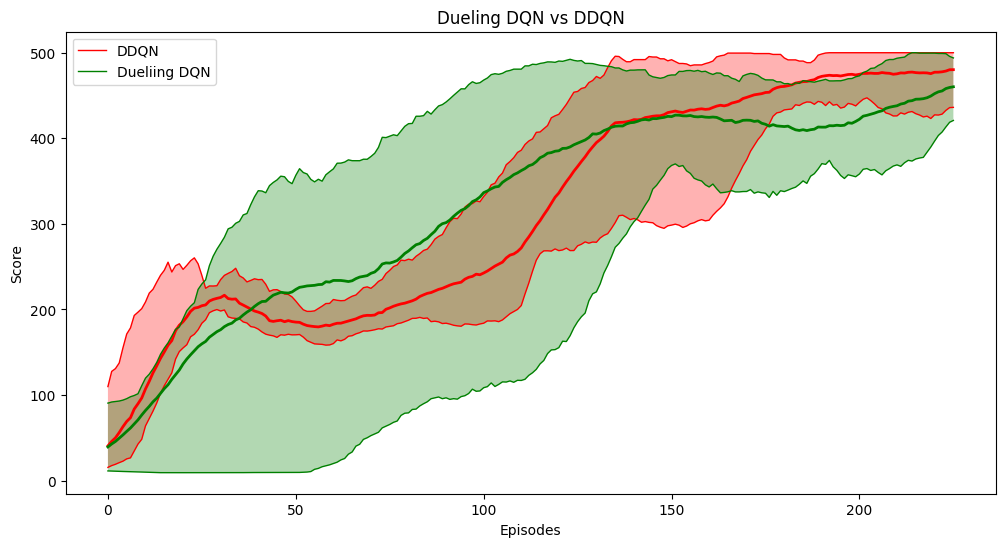

In [ ]:
plt.figure(figsize=(12,6));
plt.title('Dueling DQN vs DDQN');
plt.ylabel('Score');
plt.xlabel('Episodes');

plt.plot(ddqn_results['max_score'], 'r', linewidth=1, label="DDQN");
plt.plot(ddqn_results['min_score'], 'r', linewidth=1);
plt.plot(ddqn_results['mean_score'], 'r', linewidth=2);
plt.fill_between(episodes, ddqn_results['min_score'], ddqn_results['max_score'], facecolor='r', alpha=0.3);

plt.plot(dueling_dqn_results['max_score'], 'g', linewidth=1, label="Dueliing DQN");
plt.plot(dueling_dqn_results['min_score'], 'g', linewidth=1);
plt.plot(dueling_dqn_results['mean_score'], 'g', linewidth=2);
plt.fill_between(episodes, dueling_dqn_results['min_score'], dueling_dqn_results['max_score'], facecolor='g', alpha=0.3);

plt.legend();
plt.show();

Dueling DDQN has similar performance in the cart-pole environment. It seems **more stable** (the max and min values are closer to the mean value), but the difference is not so evident in this simple environment.

## The deadly triad

All of those improvements can be combined together in several different ways in order to achieve better performance and stability. For example you can consider the **Rainbow algorithm** ([Hessel et al. **"Rainbow: Combining Improvements in Deep Reinforcement Learning"**, AAAI, 2017](./papers/2017%20-%20Rainbow%20-%20Combining%20Improvements%20in%20Deep%20Reinforcement%20Learning.pdf)). In any way, all those value-based methods are really **sensitive to hyperparameters**. Try it for yourself: change any hyperparameter and you  will find more values that doesn’t work than values that do. Second, value-based methods **assume they interact with a Markovian environment**  (state contains all information required by the agent) and this assumption dissipates as we move away from bootstrapping and value-based methods in general. Finally, **the combination of bootstrapping, off-policy learning, and function approximator** is known as **the deadly triad** ([van Hasselt et al. **"Deep Reinforcement Learning and the Deadly Triad"**, 2018](./papers/2018%20-%20Deep%20Reinforcement%20Learning%20and%20the%20Deadly%20Triad.pdf) tworks, replay buffers, double learning, sufficiently small learning rates (but not too small), and maybe a little bit of patience.